In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    ordered_col = ['Age range']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']

    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 10', '10-17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Age range', 'Type', 'Gender', 'Officer-defined ethnicity', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Age range,Type,Gender,Officer-defined ethnicity,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.826087,0.666667,0.5,0.54514,0.503851,0.499512,0.55516,0.0,0.584645,0.698278
1,0.0,1.0,0.73913,1.0,1.0,0.484365,0.503851,0.487024,0.55516,0.0,0.252933,0.739332
2,0.333333,0.0,0.652174,0.333333,0.5,0.484365,0.503851,0.499512,0.55516,0.0,0.511023,0.65343
3,0.0,0.0,0.391304,0.333333,0.5,0.484365,0.503851,0.499512,0.55516,0.0,0.471838,0.539571
4,0.333333,0.0,0.73913,0.166667,0.75,0.54514,0.503851,0.499512,0.55516,0.0,0.50235,0.695199
...,...,...,...,...,...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.75,0.54514,0.503851,0.499512,0.55516,0.0,0.063275,0.40027
98770,0.0,1.0,0.565217,0.166667,0.75,0.484365,0.503851,0.513135,0.55516,0.0,0.27568,0.777481
98771,1.0,1.0,0.217391,0.333333,1.0,0.54514,0.503851,0.499512,0.55516,0.0,0.464807,0.526711
98772,1.0,1.0,0.695652,0.833333,0.25,0.484365,0.503851,0.499512,0.331967,0.0,0.659453,0.522612


# Check All Models

In [5]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56202155 0.56313424 0.56422605 0.56129552 0.56429156]


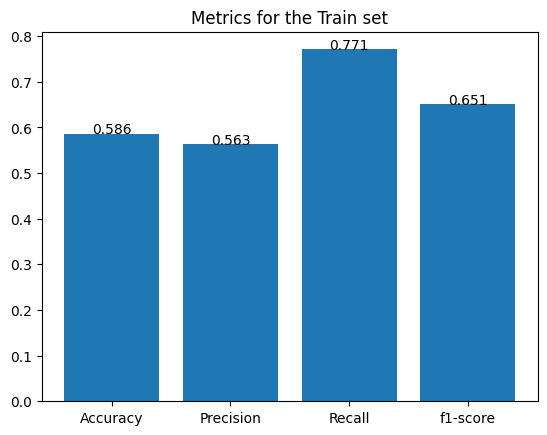

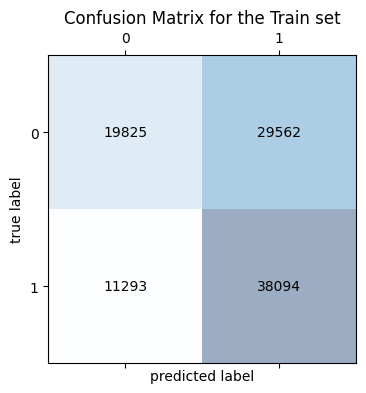

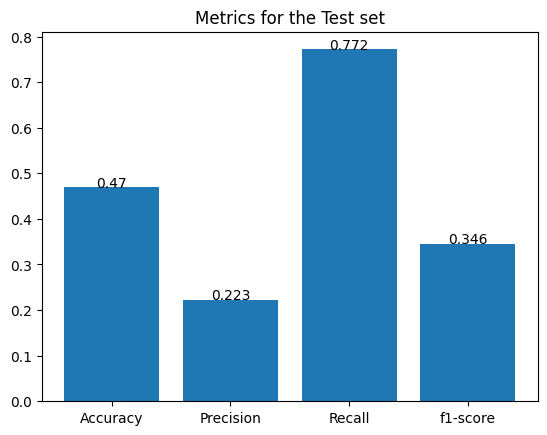

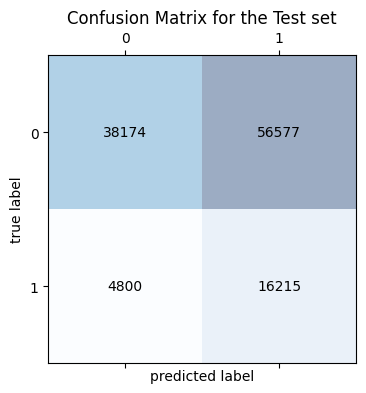

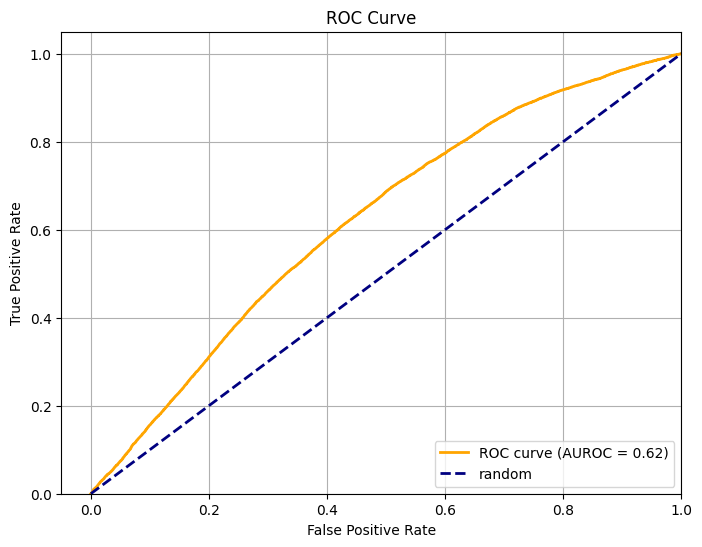

In [6]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [7]:
model = LogisticRegression()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

[0.55907251 0.55832373 0.55748468 0.55473138 0.56105855]


/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


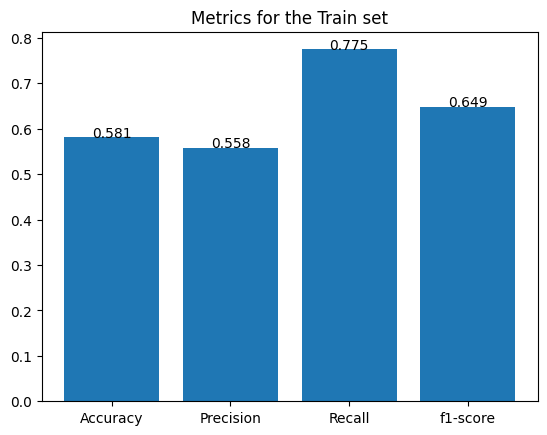

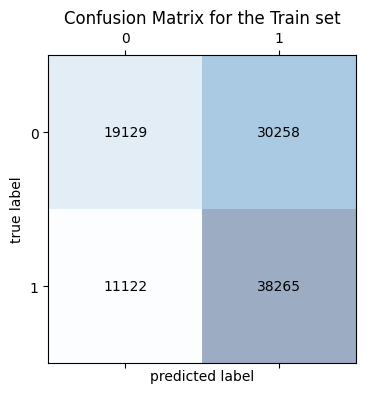

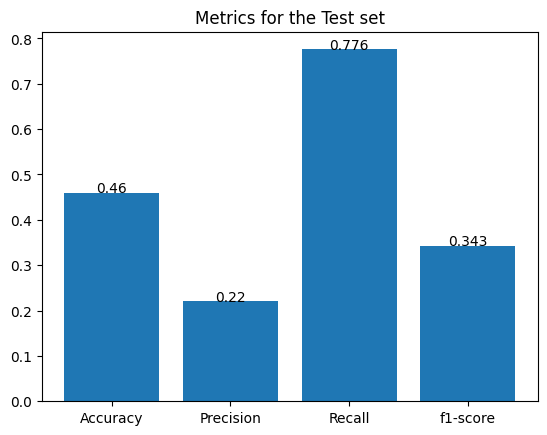

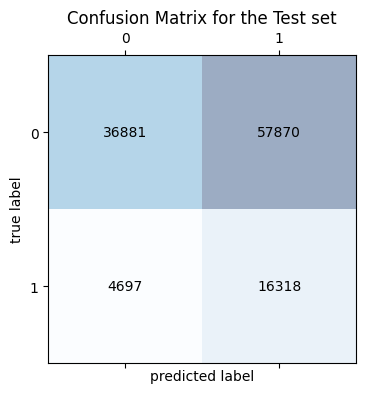

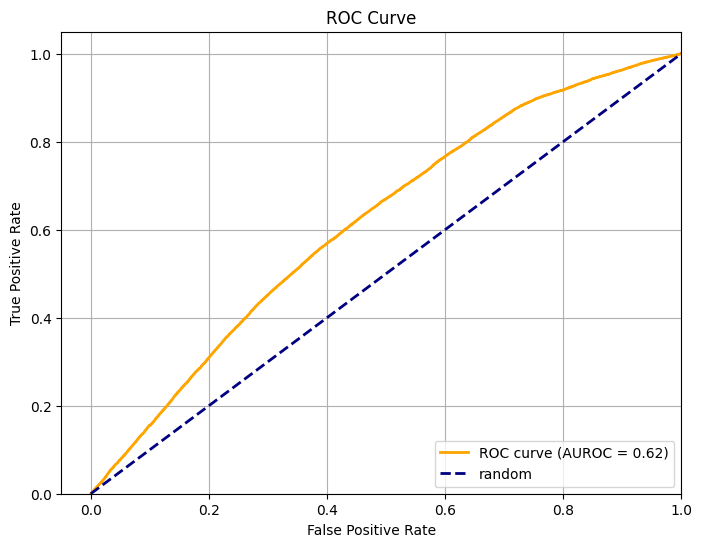

In [8]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [9]:
model = DecisionTreeClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.55851225 0.55953733 0.56999282 0.56587629 0.56618869]


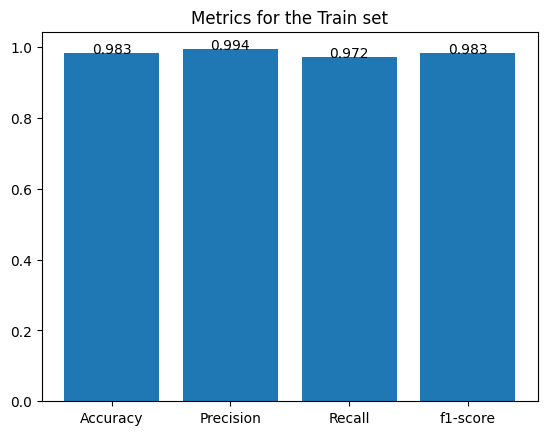

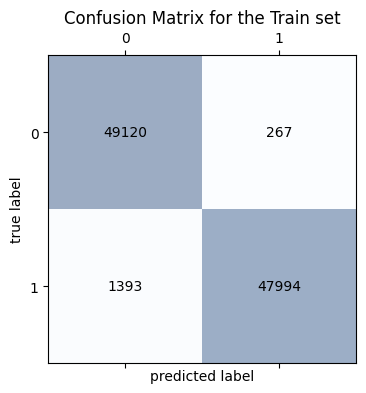

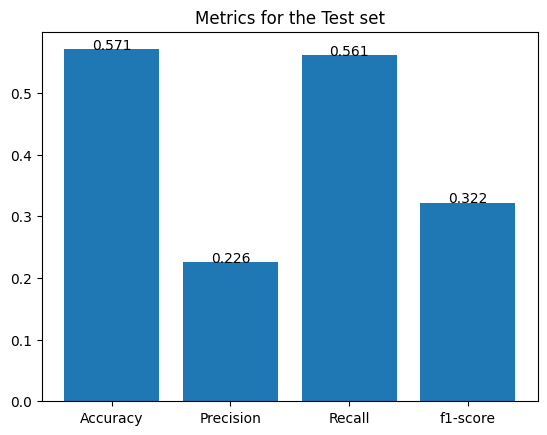

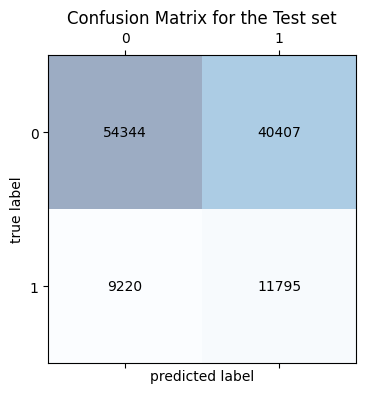

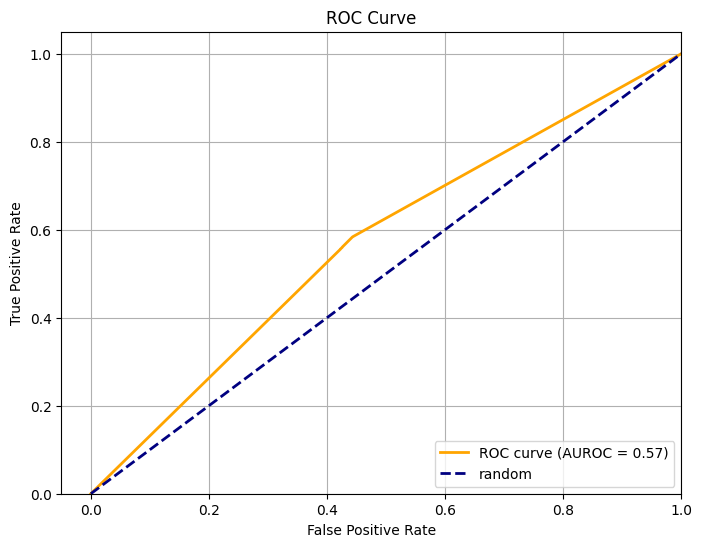

In [10]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [13]:
model = LinearSVC()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.55859603 0.5583603  0.55670776 0.55507745 0.56088425]


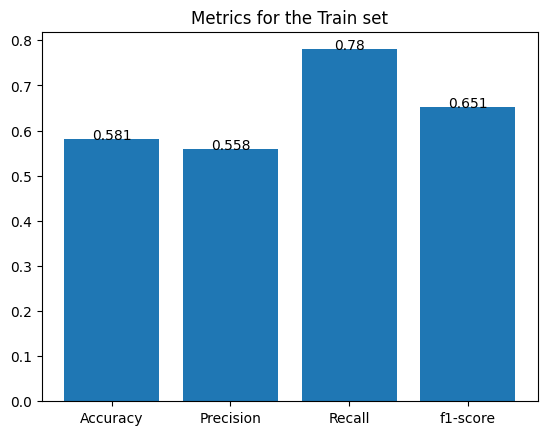

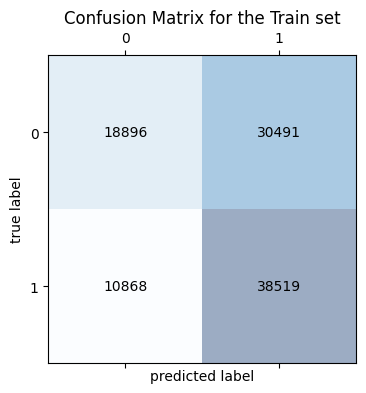

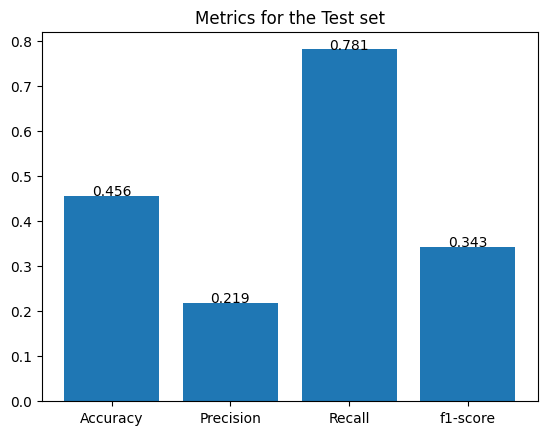

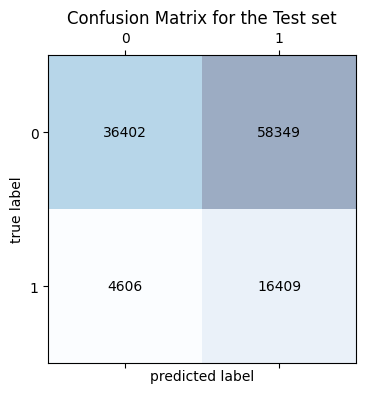

In [15]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
# y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

# aux_functions.plot_roc_curve(y_test, y_hat)

In [16]:

model = KNeighborsClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56462787 0.56144839 0.56526429 0.56450498 0.56401723]


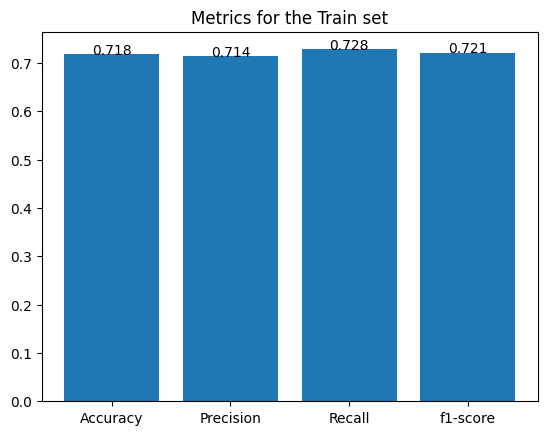

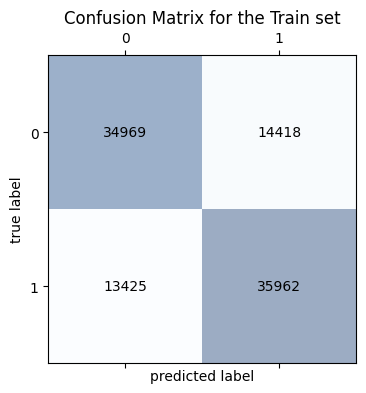

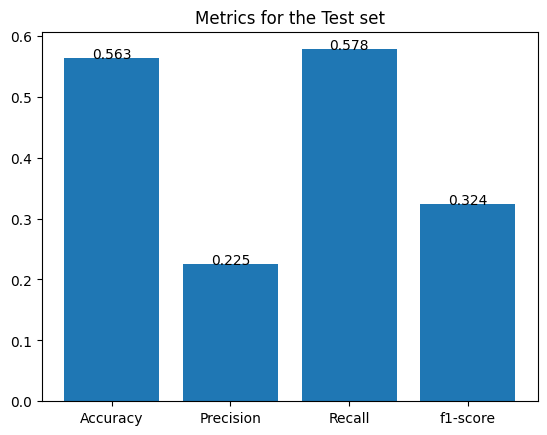

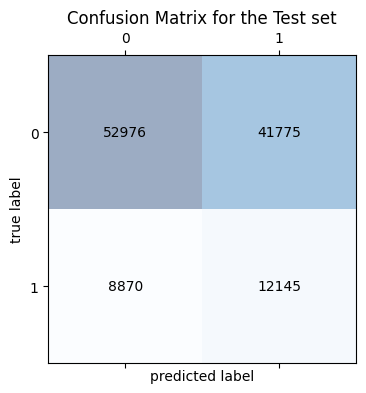

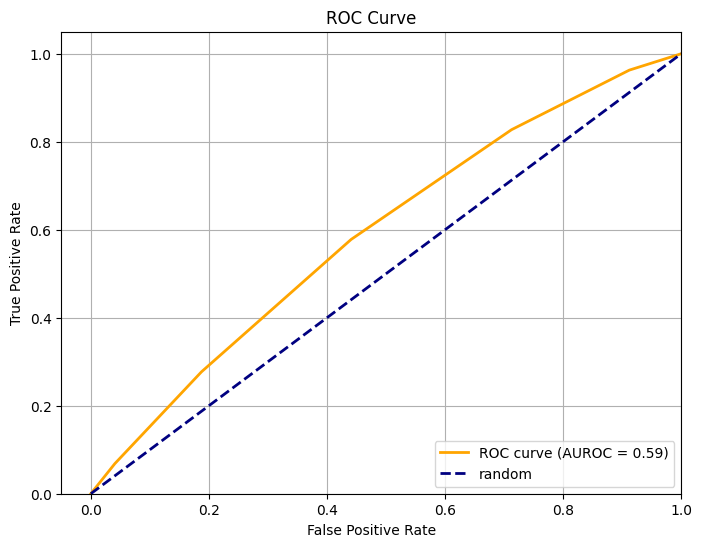

In [17]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [18]:

model = RandomForestClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.6073673  0.60315769 0.60829762 0.60708329 0.60777385]


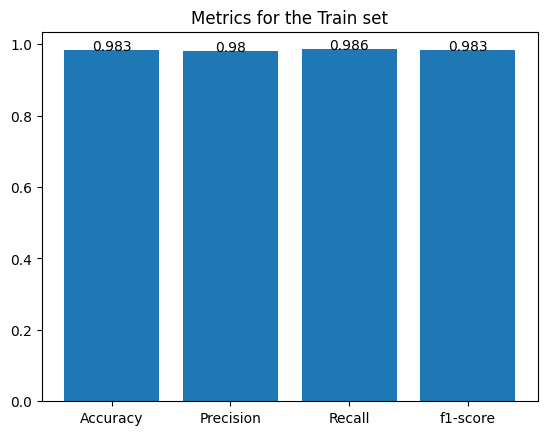

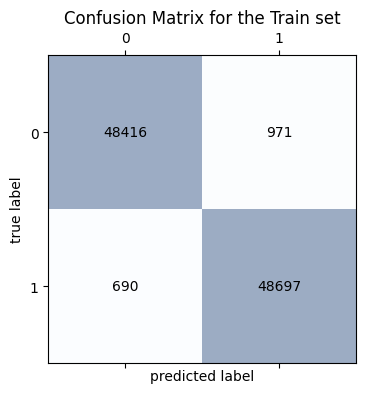

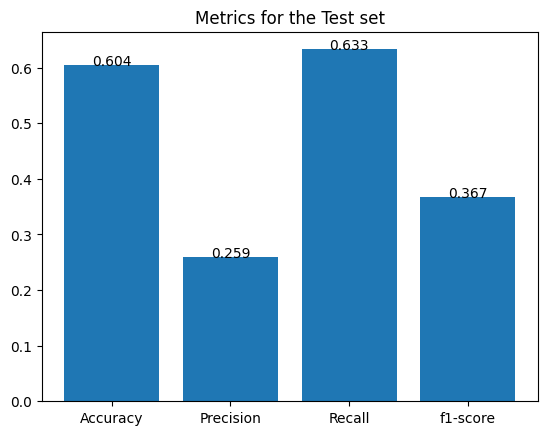

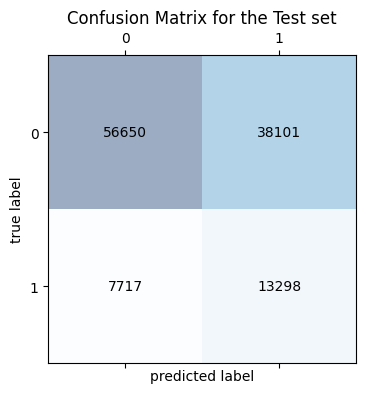

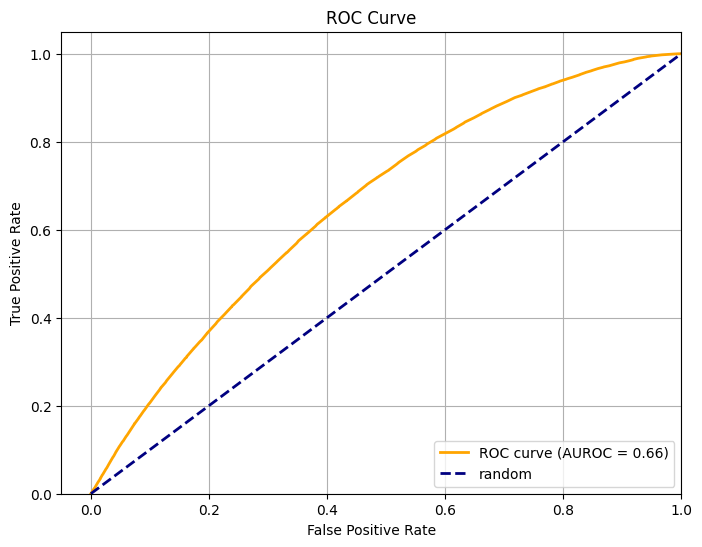

In [19]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [20]:
model = GradientBoostingClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.60602357 0.60332847 0.6019476  0.60083196 0.60478831]


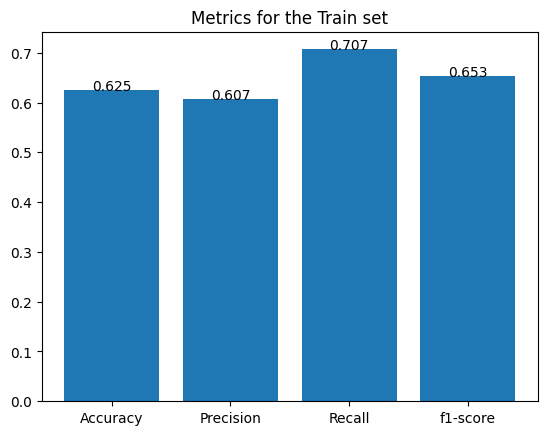

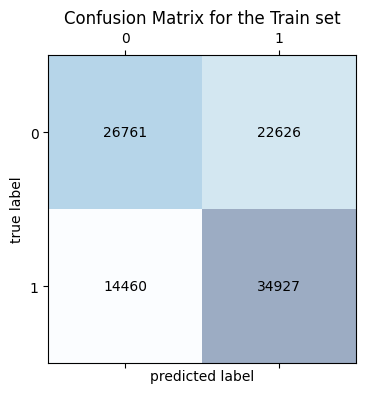

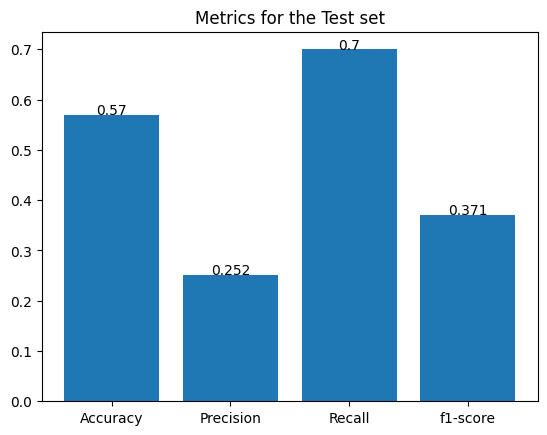

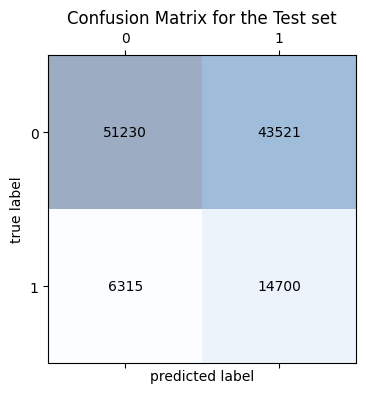

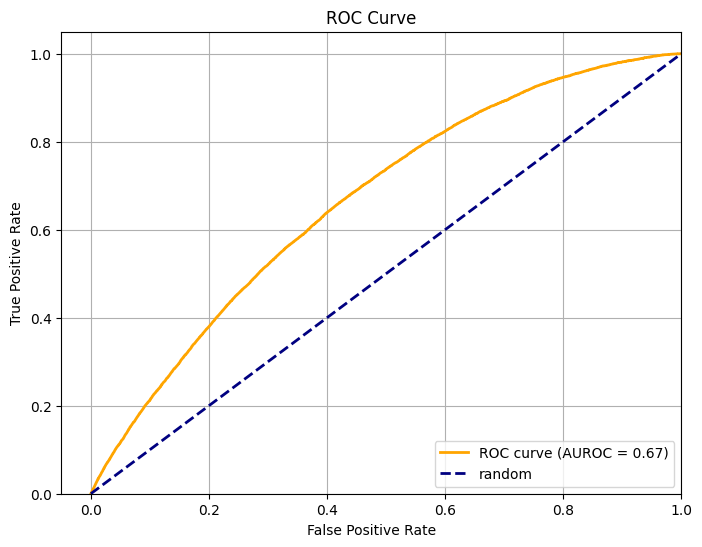

In [21]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

# Train Best Model

The best model seems to be: Naive Bayes
It was less prone to overfit while still having a decent value of Precision, Recall and AUROC.


In [12]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

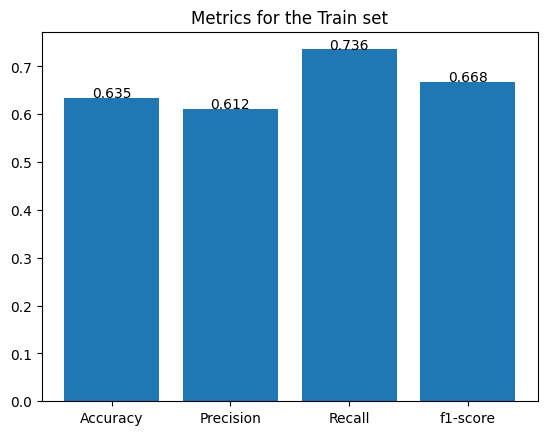

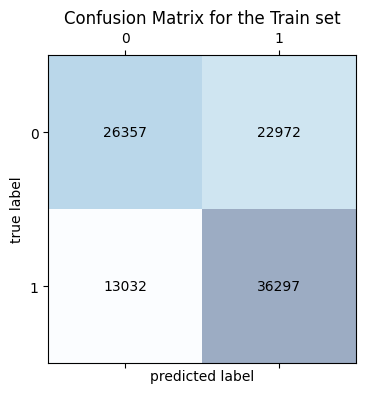

In [13]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

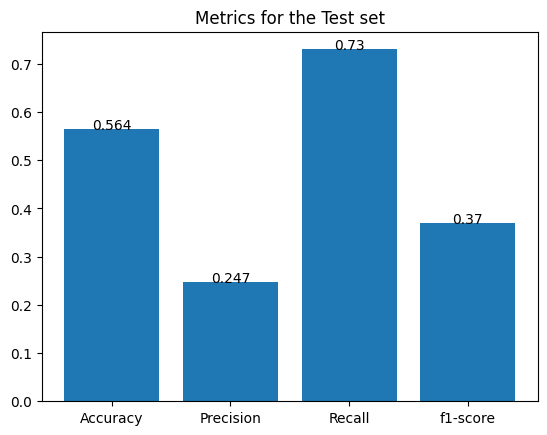

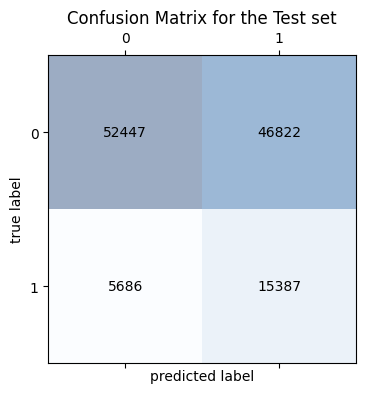

In [14]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

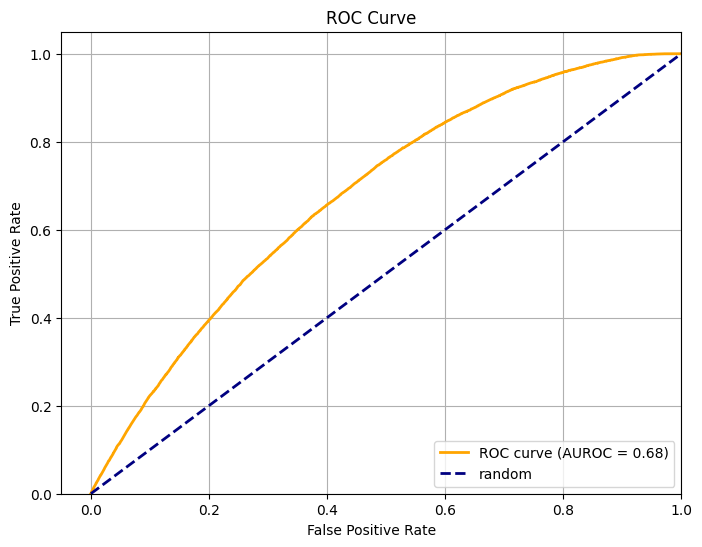

In [15]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [16]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.24734363195036088)

In [17]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Race
Requirement failed
Global rates: {'Black': 0.24323550465282748, 'White': 0.25046629927935565, 'Mixed': 0.2585278276481149, 'Asian': 0.22976459206707514, 'Other': 0.23501945525291829}
Num problematic departments: 27
Num good departments: 2
avg diff: 0.16694299494202788


In [18]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Gender
Requirement failed
Global rates: {'Male': 0.24999115513886433, 'Female': 0.22013254522658068, 'Other': 0.2708333333333333}
Num problematic departments: 14
Num good departments: 18
avg diff: 0.1404247896470351


In [19]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'18-24': 0.2721347898537308, '10-17': 0.21067565171129632, '25-34': 0.24290097629009763, 'over 34': 0.21437795953508396, 'under 10': 0.24}
Num problematic departments: 27
Num good departments: 2
avg diff: 0.15694931594350922
